In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import concurrent.futures

In [2]:
def get_seg_map(depth, bev, K):
    baseline = 0.2
    cam_height = 1.0
#     K = np.zeros((4,4))
#     K[0,0] = 320
#     K[1,1] = 320
#     K[0,2] = 240
#     K[1,2] = 240
#     K[2,2] = 1
#     K[3,3] = 1

    inv_K = np.linalg.inv(K[:3,:3])

    h, w = depth.shape
#     print(h, w)

    img_rect = np.concatenate([np.indices((w, h)), np.ones((1, w, h))], axis=0)

    pc = (inv_K @ img_rect.reshape((3, -1))).reshape((3, w, h))
    pc = pc.transpose((0,2,1)) * depth
    pc = pc.reshape((3, -1))

    pc = np.concatenate([pc, np.ones((1, h*w))], axis=0)

    bev_size = (3.2, 3.2) # m
    bev_res = bev_size[0] / bev.shape[0]
    
    cam_to_agent = np.eye(4)
#     cam_to_agent[0, 3] = -0.1
#     cam_to_agent[2, 3] = -0.1

    T = np.zeros((4, 4))
    T[0,0] = 1
    T[1,2] = -1
    T[2,1] = 1
    T[3,3] = 1
    T[0,3] = 1.6
    T[1,3] = 3.2

    ortho_cam_points = (T @ cam_to_agent @ pc) // bev_res
    valid = (ortho_cam_points[0] >= 0) & (ortho_cam_points[0] < bev.shape[1]) & (ortho_cam_points[1] >= 0) & (ortho_cam_points[1] < bev.shape[0]) & (ortho_cam_points[2] >= 0)

    pt_bev_indices = (ortho_cam_points[1, valid]*bev.shape[1] + ortho_cam_points[0, valid]).astype(int)
    pt_bev_cls = np.take(bev.reshape(-1), pt_bev_indices)

    seg_map = np.zeros(w * h, dtype=np.uint8)
    seg_map[valid] = pt_bev_cls
    seg_map = seg_map.reshape((h, w))
    
    return seg_map

In [3]:
def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

In [4]:
data_dir = '/scratch/shantanu/gibson4/new'
bev_dir = '/scratch/shantanu/final_results/gibson4/basic_transformer2/'
semantic_dir = '/scratch/shantanu/gibson4/semantics'

True

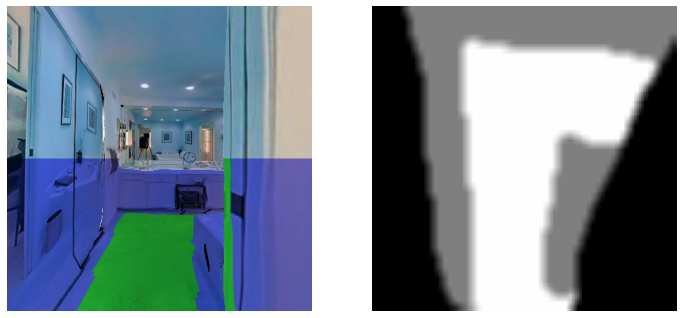

In [53]:
scene = 'Mosquito'
fileidx = 181
bev_shape = (128, 128)
img_shape = w,h = (512, 512)
floor_semantic_classes = [3, 28]


org_shape = (1024, 1024)

f = (org_shape[0] * h) / (2 * org_shape[1])

K = camera_intrinsic_transform(f_x=f, c_x=w/2, f_y=f, c_y=h/2)

rgb_fp = os.path.join(data_dir, scene, '0', 'front', 'RGB', f'{fileidx}.jpg')
depth_fp = os.path.join(data_dir, scene, '0', 'front', 'DEPTH', f'{fileidx}.png')
bev_fp = os.path.join(bev_dir, scene, 'front', f'{fileidx}.png')


rgb = cv2.cvtColor(cv2.imread(rgb_fp, -1), cv2.COLOR_BGR2RGB)
depth = np.array(cv2.imread(depth_fp, -1)).astype(np.float32)/6553.5

bev = cv2.imread(bev_fp, -1)#[64:, 32:96]

kernel = np.ones((5,5),np.float32)/25
bev = cv2.filter2D(bev,-1,kernel)



width_ar = int(rgb.shape[1] * img_shape[0] / rgb.shape[0])
rgb = cv2.resize(rgb, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
rgb = rgb[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
depth = cv2.resize(depth, dsize=(width_ar, img_shape[0]), interpolation=cv2.INTER_NEAREST)
depth = depth[:img_shape[0], (width_ar - img_shape[1])//2 : (width_ar + img_shape[1])//2]
bev = cv2.resize(bev, dsize=bev_shape, interpolation=cv2.INTER_NEAREST)
# bev = 255-bev


bev_seg = get_seg_map(depth, bev, K)
# print(np.unique(bev_seg))


# overlay = np.copy(rgb) //2
# overlay[bev_seg==127, 0] *= 3
# overlay[bev_seg==254, 1] *= 3
# overlay[bev_seg==0, 2] *= 3

# print(np.unique(bev_seg))
overlay = np.copy(rgb) //4


overlay[(np.multiply(bev_seg>100 ,bev_seg <200)), 1]*= 2
overlay[(np.multiply(bev_seg>100 ,bev_seg <200)), 0]*= 4
overlay[(np.multiply(bev_seg>100 ,bev_seg <200)), 2] *= 2

overlay[bev_seg>200, 1] *= 4
overlay[bev_seg==0] *= 4

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 18))
ax = axes.flatten()
ax[0].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(bev, cv2.COLOR_BGR2RGB))
ax[1].axis('off')

res_dir = '/scratch/shantanu/figure_output'
cv2.imwrite(res_dir+'/'+'overlay.png',overlay)
cv2.imwrite(res_dir+'/'+'original.png',rgb)

cv2.imwrite(res_dir+'/bev.png',bev)


# ax[1].imshow(depth_diff * seg)
# ax[1].text(20, 160, ' a1: {:.2f}\n a2: {:.2f}\n a3: {:.2f}\n'.format(*error_metrics[4:]), fontsize = 22)
# ax[2].imshow(tgt_bev)
# ax[3].imshow(bev)
# # ax[4].imshow(get_seg_map(depth, tgt_bev))
# ax[5].imshow(bev_seg)